<a href="https://colab.research.google.com/github/ProtossDragoon/paper_implementation_and_testing_tf2/blob/main/utils/Convert_TFTRT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convert TFTRT

## Author

name : Janghoo Lee <br>
github : https://github.com/ProtossDragoon <br>
contact : dlwkdgn1@naver.com <br>
circle : https://github.com/sju-coml <br>
organization : https://web.deering.co/ <br>
published date : June, 2021

## ThridParty

- wandb
- albumentations
- segmentation library


## Related Notebook

[Notebook](https://github.com/ProtossDragoon/paper_implementation_and_testing_tf2/blob/main/notebooks/sm_unet_test.ipynb)

# Environment

## Import

In [67]:
import tensorflow as tf
print(tf.__version__)
%load_ext tensorboard

2.5.0
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [68]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import cv2
import time

## Show HW Spec and Setup HW

### COLAB CPU

In [69]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 85
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
stepping	: 3
microcode	: 0x1
cpu MHz		: 2000.174
cache size	: 39424 KB
physical id	: 0
siblings	: 4
core id		: 0
cpu cores	: 2
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm mpx avx512f avx512dq rdseed adx smap clflushopt clwb avx512cd avx512bw avx512vl xsaveopt xsavec xgetbv1 xsaves arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa
bogomips	:

### COLAB GPU

In [70]:
!nvidia-smi -L
device_name = tf.test.gpu_device_name()
if not device_name:
  raise SystemError('GPU device not found')
print('total {} GPU devices: {}'.format(len(tf.config.list_logical_devices('GPU')), tf.config.list_logical_devices('GPU')))

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-af06844a-b619-f2ba-817b-f814dadf8dda)
total 1 GPU devices: [LogicalDevice(name='/device:GPU:0', device_type='GPU')]


### HW usage monitoring tool

In [71]:
%cd /content/
!pip install wandb -q
import wandb
wandb.init()
# clik link below

/content


## Global Hyper Parameters

In [72]:
HOME_DIR = "/content/gdrive/MyDrive"
WS = os.path.join(HOME_DIR, "ColabWorkspace")
DATA_DIR = os.path.join(HOME_DIR, 'data')

GIT_REPO_NAME = 'paper_implementation_and_testing_tf2'
GIT_WS = os.path.join(WS, GIT_REPO_NAME)

LOG_DIR = os.path.join(GIT_WS, 'tboard')
MODEL_PLOT_DIR = os.path.join(GIT_WS, 'plotmodel')
MODELS_DIR = os.path.join(GIT_WS, 'models')
TRTMODELS_DIR = os.path.join(GIT_WS, 'trtmodels')

In [73]:
GIT_BRANCH = 'tftrt'
GIT_USERNAME = None # Add here
GIT_EMAIL = None
GIT_PASSWORD = None # Add here

## Google Drive / Git

In [74]:
#!rm -r /content/gdrive/
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [75]:
%cd {GIT_WS}
!git config --global user.name {GIT_USERNAME}
!git config --global user.email {GIT_EMAIL}
!git checkout -b {GIT_BRANCH}
!git push origin {GIT_BRANCH}
!git branch --set-upstream-to origin/{GIT_BRANCH}

/content/gdrive/MyDrive/ColabWorkspace/paper_implementation_and_testing_tf2
fatal: A branch named 'tftrt' already exists.
fatal: could not read Username for 'https://github.com': No such device or address
error: the requested upstream branch 'origin/tftrt' does not exist
hint: 
hint: If you are planning on basing your work on an upstream
hint: branch that already exists at the remote, you may need to
hint: run "git fetch" to retrieve it.
hint: 
hint: If you are planning to push out a new local branch that
hint: will track its remote counterpart, you may want to use
hint: "git push -u" to set the upstream config as you push.


In [76]:
!mkdir -p {WS}
%cd {WS}
!git clone https://github.com/ProtossDragoon/{GIT_REPO_NAME}.git

!mkdir -p {LOG_DIR}
!mkdir -p {MODEL_PLOT_DIR}
!mkdir -p {WEIGHTS_DIR}
!mkdir -p {MODELS_DIR}
!mkdir -p {TRTMODELS_DIR}

/content/gdrive/MyDrive/ColabWorkspace
fatal: destination path 'paper_implementation_and_testing_tf2' already exists and is not an empty directory.


# Convert

## Your Model

### Hyper Parameters

In my case,

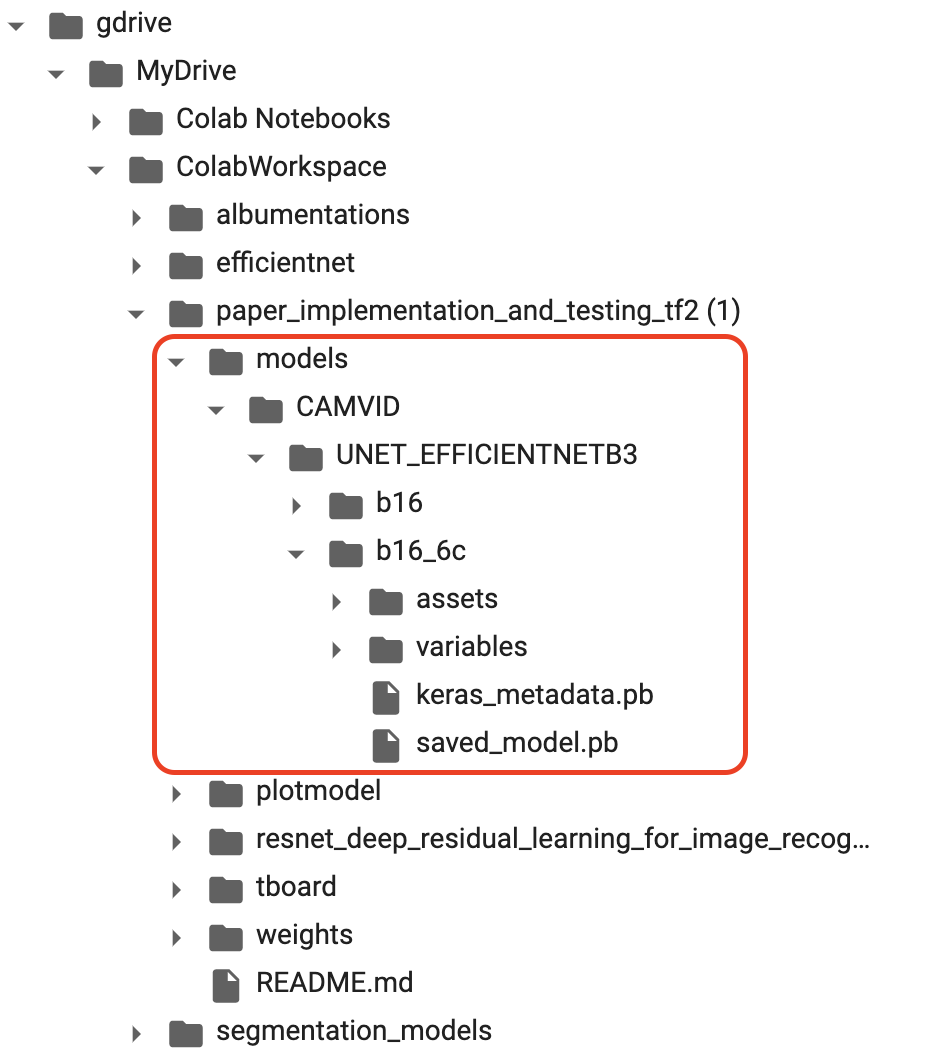

In [77]:
DATASET_NAME = 'CAMVID' #@param {type:"string"}
MODEL_INFO = 'UNET_EFFICIENTNETB3' #@param {type:"string"}
MODEL_NAME = 'b16_6c' #@param {type:"string"}

SAVEDMODEL_DIR = os.path.join(MODELS_DIR,upper(), DATASET_NAME.upper(), MODEL_NAME.upper())

GPU_DEVICE_NAME = 'tesla_p100' #@param {type:"string"}
QUANTIZATION_MODE = 'FP16' #@param ['INT8', 'FP32', 'FP16']
MAX_GPU_SIZE_MB = 2*1024 #@param
INPUT_BATCH = 1 #@param
INPUT_WIDTH =  480 #@param
INPUT_HEIGHT =  320 #@param
INPUT_CHANNEL =  3 #@param
IS_THERE_DYNAMIC_ELEMENT = 'Yes' #@param ['Yes'] # 'no' does not support on TF2

# Keras Model 은 일반적으로 'serve' 로 내보내짐.
# Keras Model 은 'serving_default' 이라는 시그니처 키값을 사용하여 model.call() 을 등록함.
SAVEDMODEL_TAG_SET = 'serve' #@param {type:"string"}
SAVEDMODEL_SIGNATURE_DEF = 'serving_default' #@param {type:"string"} 

def fake_dataset():
    input_shape = (INPUT_BATCH, INPUT_HEIGHT, INPUT_WIDTH, INPUT_CHANNEL)
    for x in input_shape:
        yield np.zeros(x).astype(np.float32) 

# about tensorrt optimizer
MINIMUN_SEGMENT_SIZE = 3 #@param
MAXIMUM_CACHED_ENGINE = 5 #@param

ADDITIONAL_DIR = os.path.join(DATASET_NAME.upper(), MODEL_INFO.upper(), MODEL_NAME)
optimized_savedmodel_fulldir = os.path.join(TRTMODELS_DIR, 
                                            GPU_DEVICE_NAME,
                                            ADDITIONAL_DIR,
                                            '{}_{:.2f}gb_b{}h{}w{}c{}_seg{}_cach{}'.format(QUANTIZATION_MODE, MAX_GPU_SIZE_MB/2**10, INPUT_BATCH, INPUT_HEIGHT, INPUT_WIDTH, INPUT_CHANNEL, MINIMUN_SEGMENT_SIZE, MAXIMUM_CACHED_ENGINE).lower())
print('Savefile Name : {}'.format(optimized_savedmodel_fulldir))

Savefile Name : /content/gdrive/MyDrive/ColabWorkspace/paper_implementation_and_testing_tf2/trtmodels/tesla_p100/CAMVID/UNET_EFFICIENTNETB3/b16_6c/fp16_2.00gb_b1h320w480c3_seg3_cach5


### Check Savedmodel

In [78]:
!saved_model_cli show --dir {SAVEDMODEL_DIR} --tag_set {SAVEDMODEL_TAG_SET} --signature_def {SAVEDMODEL_SIGNATURE_DEF}

The given SavedModel SignatureDef contains the following input(s):
  inputs['input_3'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, -1, -1, 3)
      name: serving_default_input_3:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['softmax'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, -1, -1, 6)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


### Data Loader

Drity code. Just think simply.

In [79]:
GIT_REPO_THIRDPARTY_NAME = 'segmentation_models'
GIT_WS_THIRDPARTY = os.path.join(WS, GIT_REPO_THIRDPARTY_NAME)
GIT_REPO_THIRDPARTY_NAME_2 = 'efficientnet'
GIT_WS_THIRDPARTY_2 = os.path.join(WS, GIT_REPO_THIRDPARTY_NAME_2)
%cd {GIT_WS_THIRDPARTY}
%cd {GIT_WS_THIRDPARTY_2}
%set_env PYTHONPATH={'/env/python'+':'+GIT_WS_THIRDPARTY+':'+GIT_WS_THIRDPARTY_2} # way1
# 등록까지 약간의 시간이 소요됨. ModuleNotFoundError: No module named 'segmentation_models'
# 강제 등록
for path in [GIT_WS_THIRDPARTY, GIT_WS_THIRDPARTY_2]: #way2
    if path not in sys.path:
        sys.path.append(path)
print(sys.path)
import albumentations as A
!pip install keras_applications>=1.0.7,<=1.0.8 -q
!pip install image-classifiers==1.0.0 -q
import segmentation_models as sm
sm.set_framework('tf.keras')
class PretrainedSpecificPreprocessing(A.core.transforms_interface.DualTransform):
    def __init__(self, fn):
        """
        Args:
            fn (callbale): data normalization function (can be specific for each pretrained neural network)
        """
        super().__init__(self)
        self.fn = fn
    def apply(self, img, **params): # target : img
        return self.fn(img)
    def apply_to_mask(self, img, **params): # target : mask
        return img
def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    _transform = [
        PretrainedSpecificPreprocessing(preprocessing_fn)
    ]
    return A.Compose(_transform)

def get_validation_augmentation(
    dataset_w=None, 
    dataset_h=None,
    model_input_w_for_valid=None,
    model_input_h_for_valid=None
    ):
    assert dataset_w is not None
    assert dataset_h is not None
    #assert model_input_w_for_valid is not None
    #assert model_input_h_for_valid is not None

    """Add paddings to make image shape divisible by 32""" #FIXME
    test_transform = [
        A.PadIfNeeded(min_height=dataset_h, min_width=dataset_w)
    ]

    if (model_input_w_for_valid is not None) and (model_input_h_for_valid is not None):
        test_transform.append(
            A.RandomCrop(height=model_input_h_for_valid, 
                         width=model_input_w_for_valid, 
                         always_apply=True))
        #assert model_input_w_for_valid//32 == 0, 'For EfficientNet'
        #assert model_input_h_for_valid//32 == 0, 'For EfficientNet'
    else:
        pass
        #assert dataset_w//32 == 0, 'For EfficientNet'
        #assert dataset_h//32 == 0, 'For EfficientNet'
        
    return A.Compose(test_transform)
    
# classes for data loading and preprocessing
class SegmentationDataset:

    """Segmentation Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_ids (list): values of classes ids
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    def __init__(self, images_dir, masks_dir, class_ids=None, augmentation=None, preprocessing=None):
        
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids] # image file paths
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids] # mask (label) file paths
        
        self.class_ids = class_ids

        # flags
        self.augmentation = augmentation
        self.preprocessing = preprocessing


    def __getitem__(self, i): # batch
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_ids]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
        
    def __len__(self):
        return len(self.ids)

class CamVidDataset(SegmentationDataset):
    """CamVid Segmentation Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        name_interested_classes (list): values of interested classes names
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """

    CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
               'tree', 'signsymbol', 'fence', 'car', 
               'pedestrian', 'bicyclist', 'unlabelled']
    
    def __init__(self, images_dir, masks_dir, name_interested_classes=None, augmentation=None, preprocessing=None):
        # convert str names to class values on masks
        class_ids = [self.CLASSES.index(cls.lower()) for cls in name_interested_classes]
        super(CamVidDataset, self).__init__(images_dir, masks_dir, class_ids=class_ids, augmentation=augmentation, preprocessing=preprocessing)

class DataLoader(tf.keras.utils.Sequence):

    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()


    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose tuple of lists (fixed)
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    

    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    

    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

BACKBONE = 'efficientnetb4' #select model
preprocess_input = sm.get_preprocessing(BACKBONE)
DATASET_DIR_CAMVID = os.path.join(DATA_DIR, 'camvid')
DATASET_TEST_X_DIR_CAMVID = os.path.join(DATASET_DIR_CAMVID, 'test')
DATASET_TEST_Y_DIR_CAMVID = os.path.join(DATASET_DIR_CAMVID, 'testannot')
NAME_INTERESTED_CLASSES = ['car', 'road', 'pavement', 'pedestrian', 'bicyclist']
DATASET_WIDTH = 480
DATASET_HEIGHT = 320
MODEL_INPUT_WIDTH_FOR_VALID = DATASET_WIDTH
MODEL_INPUT_HEIGHT_FOR_VALID = DATASET_HEIGHT
XY_test = CamVidDataset(
    DATASET_TEST_X_DIR_CAMVID,
    DATASET_TEST_Y_DIR_CAMVID, 
    name_interested_classes=NAME_INTERESTED_CLASSES, 
    augmentation=get_validation_augmentation(dataset_w=DATASET_WIDTH,
                                             dataset_h=DATASET_HEIGHT,
                                             model_input_w_for_valid=MODEL_INPUT_WIDTH_FOR_VALID,
                                             model_input_h_for_valid=MODEL_INPUT_HEIGHT_FOR_VALID),
    preprocessing=get_preprocessing(preprocess_input),
)
test_dataloader = DataLoader(XY_test, batch_size=1, shuffle=True)
def input_fn():
    for i in range(len(test_dataloader)):
        img, mask = test_dataloader[i]
        print('step', i+1, 'img :', img.shape, 'label :', mask.shape)
        yield [img.astype(np.float32)] # each element : signature input. So, len(return) == number of inputs
        if i > 30:
            break

/content/gdrive/MyDrive/ColabWorkspace/segmentation_models
/content/gdrive/MyDrive/ColabWorkspace/efficientnet
env: PYTHONPATH=/env/python:/content/gdrive/MyDrive/ColabWorkspace/segmentation_models:/content/gdrive/MyDrive/ColabWorkspace/efficientnet # way1
['', '/content', '/env/python', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.7/dist-packages/IPython/extensions', '/root/.ipython', '/content/gdrive/MyDrive/ColabWorkspace/segmentation_models', '/content/gdrive/MyDrive/ColabWorkspace/efficientnet']
/bin/bash: =1.0.8: No such file or directory


### Run Conversion

In [80]:
from tensorflow.python.compiler.tensorrt import trt_convert as trt

# Conversion Parameters 
conversion_params = trt.TrtConversionParams(
    precision_mode=QUANTIZATION_MODE,
    # is_dynamic_op=False if IS_THERE_DYNAMIC_ELEMENT == 'No' else True,
    max_workspace_size_bytes=MAX_GPU_SIZE_MB<<20,
    minimum_segment_size=MINIMUN_SEGMENT_SIZE,
    maximum_cached_engines=MAXIMUM_CACHED_ENGINE,
    use_calibration=True # This argument is ignored if precision_mode is not INT8.
    )

# Converter method used to partition and optimize TensorRT compatible segments
if QUANTIZATION_MODE.lower() == 'int8':
    if IS_THERE_DYNAMIC_ELEMENT == 'No':
        print('Static mode does not support post-training quantization (INT8 calibration).')
    #conversion_params._replace(is_dynamic_op=True)

converter = trt.TrtGraphConverterV2(
    input_saved_model_dir=SAVEDMODEL_DIR,
    input_saved_model_tags=SAVEDMODEL_TAG_SET,
    input_saved_model_signature_key=SAVEDMODEL_SIGNATURE_DEF,
    conversion_params=conversion_params
    )

if QUANTIZATION_MODE.lower() == 'int8':
    converter.convert(
        calibration_input_fn=input_fn
        )
else:
    converter.convert()

# Optionally, build TensorRT engines before deployment to save time at runtime
# Note that this is GPU specific, and as a rule of thumb, we recommend building at runtime
converter.build(input_fn=input_fn)

# Save the model to the disk
converter.save(optimized_savedmodel_fulldir)

INFO:tensorflow:Linked TensorRT version: (0, 0, 0)
INFO:tensorflow:Loaded TensorRT version: (0, 0, 0)
step 1 img : (1, 320, 480, 3) label : (1, 320, 480, 6)
step 2 img : (1, 320, 480, 3) label : (1, 320, 480, 6)
step 3 img : (1, 320, 480, 3) label : (1, 320, 480, 6)
step 4 img : (1, 320, 480, 3) label : (1, 320, 480, 6)
step 5 img : (1, 320, 480, 3) label : (1, 320, 480, 6)
step 6 img : (1, 320, 480, 3) label : (1, 320, 480, 6)
step 7 img : (1, 320, 480, 3) label : (1, 320, 480, 6)
step 8 img : (1, 320, 480, 3) label : (1, 320, 480, 6)
step 9 img : (1, 320, 480, 3) label : (1, 320, 480, 6)
step 10 img : (1, 320, 480, 3) label : (1, 320, 480, 6)
step 11 img : (1, 320, 480, 3) label : (1, 320, 480, 6)
step 12 img : (1, 320, 480, 3) label : (1, 320, 480, 6)
step 13 img : (1, 320, 480, 3) label : (1, 320, 480, 6)
step 14 img : (1, 320, 480, 3) label : (1, 320, 480, 6)
step 15 img : (1, 320, 480, 3) label : (1, 320, 480, 6)
step 16 img : (1, 320, 480, 3) label : (1, 320, 480, 6)
step 17 img

In [81]:
!saved_model_cli show --dir {optimized_savedmodel_fulldir} --tag_set {SAVEDMODEL_TAG_SET} --signature_def {SAVEDMODEL_SIGNATURE_DEF}

The given SavedModel SignatureDef contains the following input(s):
  inputs['input_3'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, -1, -1, 3)
      name: serving_default_input_3:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['softmax'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, -1, -1, 6)
      name: PartitionedCall:0
Method name is: tensorflow/serving/predict


### Speed Benchmark

In [106]:
def benchnmark_model_speed(model, benchmark_dtype=['fp32'], model_name='default'):
    for e in benchmark_dtype:
        assert e in ['uint8', 'fp16', 'fp32'] 
    ret = {}
    for dtype in benchmark_dtype:
        time_li = []
        if dtype == 'uint8':
            np_dtype = np.int8
            tf_dtype = tf.int8
        elif dtype == 'fp16':
            np_dtype = np.float16
            tf_dtype = tf.int16
        elif dtype == 'fp32':
            np_dtype = np.float32
            tf_dtype = tf.float32
        else:
            raise NotImplementedError
        for i in range(10):
            data = np.random.normal(size=(INPUT_BATCH, INPUT_HEIGHT, INPUT_WIDTH, INPUT_CHANNEL)).astype(np_dtype)
            x = tf.constant(data, dtype=tf_dtype)

            s = time.time()
            model_org(x) # inference
            e = time.time()
            time_li.append(e - s)

        time_li = np.array(time_li)
        avg_time = np.average(time_li)
        ret[dtype] = avg_time
        print('{} {} : {:2f} fps. (inference time average : {:3f})'.format(model_name, dtype, 1/avg_time, avg_time))
    return ret

#### [Choice] Keras API

In [108]:
# load with keras api
print('a :', SAVEDMODEL_DIR)
print('b :', optimized_savedmodel_fulldir)
model_org = tf.keras.models.load_model(SAVEDMODEL_DIR, compile=False)
model_trt = tf.keras.models.load_model(optimized_savedmodel_fulldir, compile=False)
print('a : {} - sigkey : {}\nb : {} - sigkey : {}'.format(type(model_org), list(model_org.signatures.keys()), 
                                                          type(model_trt), list(model_trt.signatures.keys())))

benchnmark_model_speed(model_org, ['uint8', 'fp16', 'fp32'], 'pure')
benchnmark_model_speed(model_trt, ['uint8', 'fp16', 'fp32'], 'trt')

a : /content/gdrive/MyDrive/ColabWorkspace/paper_implementation_and_testing_tf2/models/CAMVID/UNET_EFFICIENTNETB3/b16_6c
b : /content/gdrive/MyDrive/ColabWorkspace/paper_implementation_and_testing_tf2/trtmodels/tesla_p100/CAMVID/UNET_EFFICIENTNETB3/b16_6c/fp16_2.00gb_b1h320w480c3_seg3_cach5
a : <class 'tensorflow.python.keras.engine.functional.Functional'> - sigkey : ['serving_default']
b : <class 'tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject'> - sigkey : ['serving_default']
pure uint8 : 6.503563 fps. (inference time average : 0.153762)
pure fp16 : 6.705049 fps. (inference time average : 0.149141)
pure fp32 : 6.662305 fps. (inference time average : 0.150098)
trt uint8 : 6.622795 fps. (inference time average : 0.150994)
trt fp16 : 6.581252 fps. (inference time average : 0.151947)
trt fp32 : 6.579345 fps. (inference time average : 0.151991)


{'fp16': 0.1519467830657959,
 'fp32': 0.15199081897735595,
 'uint8': 0.1509936571121216}

#### [Choice] TensorFlow API

In [109]:
# If the model does not saved with tf.keras.save_model()
print('a :', SAVEDMODEL_DIR)
print('b :', optimized_savedmodel_fulldir)
model_org_tf = tf.saved_model.load(SAVEDMODEL_DIR, tags=SAVEDMODEL_TAG_SET)
model_trt_tf = tf.saved_model.load(optimized_savedmodel_fulldir, tags=SAVEDMODEL_TAG_SET)
print('a : {} - sigkey : {}\nb : {} - sigkey : {}'.format(type(model_org_tf), list(model_org_tf.signatures.keys()), 
                                                          type(model_trt_tf), list(model_trt_tf.signatures.keys())))

f = model_org_tf.signatures[SAVEDMODEL_SIGNATURE_DEF]
benchnmark_model_speed(f, ['uint8', 'fp16', 'fp32'], 'pure')
f = model_trt_tf.signatures[SAVEDMODEL_SIGNATURE_DEF]
benchnmark_model_speed(f, ['uint8', 'fp16', 'fp32'], 'trt')

a : /content/gdrive/MyDrive/ColabWorkspace/paper_implementation_and_testing_tf2/models/CAMVID/UNET_EFFICIENTNETB3/b16_6c
b : /content/gdrive/MyDrive/ColabWorkspace/paper_implementation_and_testing_tf2/trtmodels/tesla_p100/CAMVID/UNET_EFFICIENTNETB3/b16_6c/fp16_2.00gb_b1h320w480c3_seg3_cach5
a : <class 'tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject'> - sigkey : ['serving_default']
b : <class 'tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject'> - sigkey : ['serving_default']
pure uint8 : 6.736145 fps. (inference time average : 0.148453)
pure fp16 : 6.861797 fps. (inference time average : 0.145734)
pure fp32 : 6.829431 fps. (inference time average : 0.146425)
trt uint8 : 6.961314 fps. (inference time average : 0.143651)
trt fp16 : 6.760927 fps. (inference time average : 0.147909)
trt fp32 : 6.894028 fps. (inference time average : 0.145053)


{'fp16': 0.14790871143341064,
 'fp32': 0.14505307674407958,
 'uint8': 0.14365103244781494}

# Debug and trial Area

In [131]:
%cd ~
"""
model_org_tf.v = tf.Variable(3.)
model_org_tf.f = tf.function(
    lambda x: model_org_tf.v * x,
    input_signature=[tf.TensorSpec(shape=None, dtype=tf.float32)]
    )
"""
@tf.function(input_signature=[tf.TensorSpec(shape=None, dtype=tf.float32)])
def maxpooling(x):
    shape = tf.shape(x)
    output = tf.nn.max_pool2d(
        x, (2,2), 1, 'VALID', data_format='NHWC', name=None
        )
    
    """
    h_lin = tf.linspace(0, shape[1]+1, shape[1], name='h_lin') # h
    w_lin = tf.linspace(0, shape[2]+1, shape[2], name='w_lin') # w


    output = (y * width + x) * channels + c 
    # [b, y, x, c]
    output - (y * width + x) * channels
    """
    return output
model_org_tf.maxpooling = maxpooling

ADDITIONAL_MAXPOOL_SIGNATURE_DEF = 'maxpooling'
signatures = {SAVEDMODEL_SIGNATURE_DEF: model_org_tf.signatures[SAVEDMODEL_SIGNATURE_DEF],
              ADDITIONAL_MAXPOOL_SIGNATURE_DEF: model_org_tf.maxpooling,
              #ADDITIONAL_MAXPOOL_SIGNATURE_DEF: model_org_tf.f
              }

tf.saved_model.save(model_org_tf, 'temp_model', signatures=signatures)
!saved_model_cli show --dir {'temp_model'} --tag_set {SAVEDMODEL_TAG_SET}
!saved_model_cli show --dir {'temp_model'} --tag_set {SAVEDMODEL_TAG_SET} --signature_def {SAVEDMODEL_SIGNATURE_DEF}
!saved_model_cli show --dir {'temp_model'} --tag_set {SAVEDMODEL_TAG_SET} --signature_def {ADDITIONAL_MAXPOOL_SIGNATURE_DEF}

model_reloaded = tf.saved_model.load('temp_model')
print(model_reloaded.signatures.keys())
model_reloaded.signatures[ADDITIONAL_MAXPOOL_SIGNATURE_DEF](
    tf.constant(
        #np.random.normal(size=(INPUT_BATCH, INPUT_HEIGHT, INPUT_WIDTH, INPUT_CHANNEL)),
        np.random.normal(size=(1, 3, 3, 2)),
        dtype=tf.float32
        )
    )

/root
INFO:tensorflow:Assets written to: temp_model/assets
The given SavedModel MetaGraphDef contains SignatureDefs with the following keys:
SignatureDef key: "__saved_model_init_op"
SignatureDef key: "maxpooling"
SignatureDef key: "serving_default"
The given SavedModel SignatureDef contains the following input(s):
  inputs['input_3'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, -1, -1, 3)
      name: serving_default_input_3:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['softmax'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, -1, -1, 6)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict
The given SavedModel SignatureDef contains the following input(s):
  inputs['x'] tensor_info:
      dtype: DT_FLOAT
      shape: unknown_rank
      name: maxpooling_x:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['output_0'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, -1, -1, -1)
   

{'output_0': <tf.Tensor: shape=(1, 2, 2, 2), dtype=float32, numpy=
 array([[[[0.6830427 , 2.5973103 ],
          [0.6830427 , 0.40352967]],
 
         [[0.6830427 , 0.40352967],
          [0.6830427 , 0.40352967]]]], dtype=float32)>}